# Desafio Properati - Limpieza de datos - Grupo 3

En este proyecto el desafío es limpiar la base de datos de inmuebles provista por Properati.

El objetivo de la limpieza es dejar listo el dataset para luego poder utilizarlo para hacer regresiones y calcular el valor de nuevas observaciones.

## ¿Cómo lo vamos a hacer?
Decidimos estructurar nuestras tareas en cuatro bloques de trabajo:
* 1: Análisis exploratorio. 
* 2: Normalizar, corregir y rellenar la informacion que lo permita, sin afectar prediciones futuras.
* 3: Quitar todo lo que no nos sirve.
* 4: Calcular las variables dummies y mostrar los resultados.

## 1. Análisis exploratorio

A partir del analisis exploratorio de los datos, ponemos a prueba algunas de las hipótesis que tendremos en cuenta para estandarizar la información. 
En los casos en los que nuestras hipótesis se corroboran, definimos las estrategias que tomaremos para corregir el dataset en el siguiente bloque de trabajo. 

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
from IPython.core.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

# usado para pruebas hechas sobre  las urls de imagenes y link a las publicaciones
import requests 
import hashlib 

In [2]:
# importo archivo
df = pd.read_csv("properatti.csv")
df.shape

(121220, 26)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

In [4]:
df.describe()

,Unnamed: 0,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,121220.000000,1.025030e+05,69670.000000,69670.000000,1.008100e+05,1.008100e+05,1.008100e+05,81892.000000,101313.000000,68617.000000,8.765800e+04,7899.000000,47390.000000,1.426200e+04
mean,60609.500000,3.574442e+06,-34.626210,-59.266290,4.685259e+05,4.229397e+06,2.397006e+05,233.795328,133.050181,2160.086916,6.912216e+03,17.452336,3.080840,5.009234e+03
std,34993.344153,3.541306e+05,1.980936,2.299922,2.260101e+06,6.904714e+06,3.913239e+05,1782.222147,724.351479,2759.288621,2.837864e+04,120.243621,1.860773,1.204403e+05
min,0.000000,3.427208e+06,-54.823985,-75.678931,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.600000,1.510204e+00,1.000000,1.000000,1.000000e+00
25%,30304.750000,3.430234e+06,-34.669065,-58.727040,1.100000e+05,1.583309e+06,8.973388e+04,50.000000,45.000000,1218.181818,1.550000e+03,1.000000,2.000000,1.000000e+03
50%,60609.500000,3.433910e+06,-34.597985,-58.480128,1.850000e+05,2.558452e+06,1.450000e+05,84.000000,75.000000,1800.000000,2.213115e+03,3.000000,3.000000,2.000000e+03
75%,90914.250000,3.836668e+06,-34.441299,-58.395908,4.200000e+05,4.675792e+06,2.650000e+05,200.000000,150.000000,2486.411765,3.355549e+03,6.000000,4.000000,4.000000e+03
max,121219.000000,6.948895e+06,4.545843,-53.733330,6.500000e+08,8.212711e+08,4.654544e+07,200000.000000,187000.000000,206333.333333,4.000000e+06,3150.000000,32.000000,1.000150e+07


In [5]:
#Obtenemos los porcentajes de datos faltantes de cada columna
for cols in df.columns:
    nulos = df[cols].isnull().sum()
    porcentaje = nulos/len(df)
    print(f'{porcentaje*100:.0f}%', cols)

0% Unnamed: 0
0% operation
0% property_type
0% place_name
0% place_with_parent_names
0% country_name
0% state_name
15% geonames_id
43% lat-lon
43% lat
43% lon
17% price
17% currency
17% price_aprox_local_currency
17% price_aprox_usd
32% surface_total_in_m2
16% surface_covered_in_m2
43% price_usd_per_m2
28% price_per_m2
93% floor
61% rooms
88% expenses
0% properati_url
0% description
0% title
3% image_thumbnail


Con respecto a los datos faltantes, rápidamente podemos descartar variables que son innecesarias, tales como:
`properati_url`, `Unnamed:0`, `lat` y `lon`. Estas últmas  2, no son necesarias ya que contamos con `lat-lon` que tiene mayor precisión.

Por otra parte, existen demasiados datos faltantes de las variables `floor` y `expenses`, por lo que sería conveniente descartarlas por completo. 

En cuanto a una las variables críticas del modelo, vemos que `rooms` tiene un 61% de datos faltantes, lo que requiere dedicación para extraer datos de los títulos y descripciones. También es alarmante que no existan datos de **baños**, **dormitorios**, **amenities** o de **cocheras**, por lo que sería conveniente al menos intentar extraer datos relacionados.

Finalmente, las variables relacionadas a las coordenadas geográficas tienen datos sobre el 57% de la muestra y lamentablemente no es factible intentar extraerla ya que no es información que se pueda conseguir en las descripciones. Afortunadamente contamos con información de los barrios y localidades en la variable `place_with_parent_names`, lo que nos permite generar dummies y calcular matrices de ponderación espacial por contigüidad.

### Trabajos exploratorios con la superficie de las propiedades:

##### Trabajo  sobre m2 en superficie total y superficie cubierta con valores invertidos:

In [6]:
# Buscamos los casos en los que la superficie total es menor que la superficie cubierta.
print("Muestra de M2 con superficie total menor que superficie cubierta")
display(df.loc[(df.surface_total_in_m2 < df.surface_covered_in_m2),["surface_total_in_m2","surface_covered_in_m2"]].sample(5))


#Suponemos que los valores de las columnas de superficie total y superficie cubierta pueden estar invertidos por error. 
#Estimamos la división de uno sobre otro para calcular la media de esta diferencia que nos permita corroborar nuestra hipótesis.
df['cubierta_sobre_total'] = df['surface_total_in_m2']/ df['surface_covered_in_m2'] 
df['total_sobre_cubierta'] = df['surface_covered_in_m2']/ df['surface_total_in_m2']
df['valores_invertidos'] = df['surface_covered_in_m2'] < df['surface_total_in_m2']

#Dropeamos los valores iguales para que no afecten el promedio.
#Observamos que son valores similares y que por lo tanto nos permiten asumir que los valores de ambas columnas fueron invertidos.
print("Resumen de la media de la relacion de variables sobre M2 (valores invertidos y no invertidos)")
display(
    df.drop(df.loc[df['surface_total_in_m2'] == df['surface_covered_in_m2']].index)\
    [["valores_invertidos","total_sobre_cubierta","cubierta_sobre_total"]].groupby(['valores_invertidos']).mean()
)

# Por esto decidimo invertir los valores de las columnas de superficie total y superficie cubierta en aquellos casos que la primera es inferior a la segunda

Muestra de M2 con superficie total menor que superficie cubierta


,surface_total_in_m2,surface_covered_in_m2
107173,42.0,305.0
45774,121.0,965.0
29347,48.0,62.0
45844,107.0,115.0
24762,122.0,156.0


Resumen de la media de la relacion de variables sobre M2 (valores invertidos y no invertidos)


,total_sobre_cubierta,cubierta_sobre_total
valores_invertidos,,
False,5.471169,0.696969
True,0.737385,inf


##### Trabajo sobre m2 en superficie total y superficie cubierta según tipo de propiedad:

In [7]:
#Contamos los casos que tienen una superficie total inferior a superficie cubierta según tipo de propiedad.
print ('Casos con superifice total inferior a superficie cubierta por tipo de propiedad')
display (df.loc[(df.surface_total_in_m2 < df.surface_covered_in_m2)]['property_type'].value_counts())

print ('--------------')

#Contamos casos segun tipo de propiedad para obtener relacion porcentual. Concluimos que no es una variable significativa para etsa relación.
print ('Casos totales por tipo de propiedad')
display (df['property_type'].value_counts())


Casos con superifice total inferior a superficie cubierta por tipo de propiedad


house        666
apartment    351
store         47
PH            42
Name: property_type, dtype: int64

--------------
Casos totales por tipo de propiedad


apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64

##### Trabajo  para completar m2 a partir del valor de la propiedad y del valor por metro:

In [8]:
# Solo puedo averiguar mi incognita si tengo metros y valor por metro
# ejemplo: x = df['price_aprox_usd']/df['price_usd_per_m2']

#Buscamos las diferentes combinaciones
print("USD, Con Precio y PPM USD pero sin M2: {}".format(
    df.loc[(~df["price_aprox_usd"].isnull()) & (~df["price_usd_per_m2"].isnull()) & (df["surface_total_in_m2"].isnull()),"operation"].count()
))
print("ARS, Con Precio y PPM ARS pero sin M2: {}".format(
    df.loc[(~df["price_aprox_local_currency"].isnull()) & (~df["price_per_m2"].isnull()) & (df["surface_total_in_m2"].isnull()),"operation"].count()
))
print("Con Precio default y PPM default pero sin M2: {}".format(
    df.loc[(~df["price"].isnull()) & (~df["price_per_m2"].isnull()) & (df["surface_total_in_m2"].isnull()),"operation"].count()
))
print("Con Precio default y PPM USD pero sin M2: {}".format(
    df.loc[(~df["price"].isnull()) & (~df["price_usd_per_m2"].isnull()) & (df["surface_total_in_m2"].isnull()),"operation"].count()
))

# Hipotesis refutada, no sirve para obtener nuevos datos

USD, Con Precio y PPM USD pero sin M2: 0
ARS, Con Precio y PPM ARS pero sin M2: 24308
Con Precio default y PPM default pero sin M2: 24308
Con Precio default y PPM USD pero sin M2: 0


##### Trabajo para completar m2 a partir de valores útiles en título y descripción:

In [9]:
#Creamos una regex  y la corremos en titulo y en descripcion para ver que encuentra
pattern= r'([\.\d]{2,99}) (?!m²|m2|mt|metro)'
m2ExtractedFromTitle=df.loc[df["surface_total_in_m2"].isnull(),'title'].str.extract(pattern, re.IGNORECASE)
m2FromDescription=df.loc[df["surface_total_in_m2"].isnull(),'description'].str.extract(pattern, re.IGNORECASE)

# Imprimir resumen resultados
print("Valores en columna titulo: {}".format(m2ExtractedFromTitle.dropna().describe().loc["count",0]))
print("Valores en columna descripcion: {}".format(m2FromDescription.dropna().describe().loc["count",0]))


# Imprimir lo encontrado en titulo.
df["m2Extracted"] = m2ExtractedFromTitle
for index,x in df.iloc[m2ExtractedFromTitle.dropna().index].loc[:,["title","m2Extracted"]].iterrows():
    print("\r Found: {}  \t Title: {}  ".format(x["m2Extracted"],x["title"]))

    
# Dropeamos columna temporal
df.drop("m2Extracted",axis=1,inplace=True)

#Tras revisar los resultados, hay muchas informacion falsa y no es confiable

Valores en columna titulo: 3195
Valores en columna descripcion: 22958
 Found: 36  	 Title: VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37                 
 Found: 7637  	 Title: WHITE 7637 - 2 DORMITORIOS CON PATIO        
 Found: 237  	 Title: EXCELENTE | MENDOZA 237 | MTS PLAZA COLO  
 Found: 509  	 Title: Venta departamento en Pasteur 509 Balvanera  
 Found: 505  	 Title: 7 e/505 y 506  
 Found: 393  	 Title: Yirigiyen 393 - Excelente ubicacion  
 Found: 1431  	 Title: Calle 8 1431 (61 y 62)  1400  
 Found: 135  	 Title: 135 e/ 531 y 32  
 Found: 62  	 Title: 62 e/ 12 y 13 800  
 Found: 27  	 Title: ITALIA Y 27 FEBRERO INSUPERABLE CASA 2 DORMIT. PATIO PARRILLERO TERRAZA 86 MTR2  
 Found: 2017  	 Title: ENTREGA 09/2017  3 AMB+COCHERA+BAULERA+AMENITIES  
 Found: 12  	 Title: GARITA 12 SALIDA A 2 CALLES Y RUTA 9 MODERNA  CASA SOBRE 1600mt.2 TERRENO   
 Found: 14  	 Title: FUNES GARITA 14 CASA 3 DORMITORIOS SUITE    
 Found: 9335  	 Title: 9335 - Hipocampo Nº 736  
 Found: 2366  	 Title: C

 Found: 375.000  	 Title: U$D 375.000 - Casa en Venta - De La Vidalita     1300  
 Found: 140.000  	 Title: U$D 140.000 - Casa en Venta - Tte C Albarracin     2900  
 Found: 149.000  	 Title: U$D 149.000 - Casa en Venta - Bermejo   
 Found: 159.000  	 Title: U$D 159.000 - Casa en Venta - Bermejo   
 Found: 230.000  	 Title: U$D 230.000 - Casa en Venta - Inte Luis Gaeberler     1000  
 Found: 129.000  	 Title: U$D 129.000 - Casa en Venta - Gdor G Udaondo     4600  
 Found: 115.000  	 Title: U$D 115.000 - Casa en Venta - Posta De Pardo     3300  
 Found: 135.000  	 Title: U$D 135.000 - Casa en Venta - Oribe     1600  
 Found: 230.000  	 Title: U$D 230.000 - Casa en Venta - E Cipolletti     500  
 Found: 290.000  	 Title: U$D 290.000 - Casa en Venta - Country El Nacional   
 Found: 113.000  	 Title: U$D 113.000 - Casa en Venta - A Lincoln     1000  
 Found: 68.000  	 Title: U$D 68.000 - Casa en Venta - Gral Angel Pacheco     1700  
 Found: 90.000  	 Title: U$D 90.000 - Casa en Venta - Alt

 Found: 003  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A003 2241)  
 Found: 004  	 Title: Piso en Venta Ciudad Autonoma de Buenos Aires / Buenos Aires (A004 3266)  
 Found: 004  	 Title: Departamento en Venta Moron / Moron (A004 3269)  
 Found: 008  	 Title: Departamento en Venta Villa Luzuriaga / La Matanza (A008 814)  
 Found: 008  	 Title: Departamento en Venta San Justo / La Matanza (A008 811)  
 Found: 008  	 Title: Departamento en Venta San Justo / La Matanza (A008 812)  
 Found: 014  	 Title: Departamento en Venta Miramar / General Alvarado (A014 2712)  
 Found: 014  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A014 2722)  
 Found: 014  	 Title: PH en Venta Ramos Mejia / La Matanza (A014 2723)  
 Found: 016  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A016 3061)  
 Found: 030  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A030 871)  
 Found: 034  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A034 1120)  
 Found: 034  

 Found: 268  	 Title: Lote 268 en Golf 1  
 Found: 1000  	 Title: Casa de 380mts sobre lote de 1000 zona residencial  
 Found: 9566  	 Title: 9566 - Pino Beach UF4   
 Found: 9567  	 Title: 9567 - Pina Beach uf16  
 Found: 3600  	 Title:  San Blas 3600 - Duplex 3 Ambientes Opcion 4 Ambientes C/esp. guardacoche  
 Found: 2019.  	 Title: Monoambiente al pozo 2019. Inversion!  
 Found: 24  	 Title: Venta 4 amb Palermo Apto Crédito seguridad 24 hs  
 Found: 97  	 Title: 97 500  
 Found: 1.6  	 Title: Vendo Quinta en Coronda - 1.6 ha con casa  
 Found: 1.100.000.  	 Title: *** SE VENDE CASA CANCELADA Y MODIFICADA *** $1.100.000.     
 Found: 500  	 Title: Tierra del Fuego 500 3 piso  
 Found: 1100  	 Title: Funcional nuevo Alvares Thomas al 1100 Capital Federal U$S 98000  
 Found: 2700  	 Title: 3 amb  venta V. Devoto ,Sanabria 2700 Apto credito  
 Found: 4300  	 Title: 3 amb venta Saavedra..Av Balbin 4300 APTO CREDITO!  
 Found: 64  	 Title: CASA EN VENTA EN 64 Y 131  
 Found: ...  	 Title

 Found: 003  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A003 2278)  
 Found: 004  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A004 2674)  
 Found: 004  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A004 3335)  
 Found: 010  	 Title: Departamento en Venta Haedo / Moron (A010 636)  
 Found: 026  	 Title: Semipiso en Venta Ramos Mejia / La Matanza (A026 1585)  
 Found: 026  	 Title: Local a la calle en Venta Ramos Mejia / La Matanza (A026 1587)  
 Found: 034  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A034 1025)  
 Found: 034  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A034 1128)  
 Found: 034  	 Title: Departamento en Venta Villa Luzuriaga / La Matanza (A034 1118)  
 Found: 034  	 Title: Departamento en Venta Villa Luzuriaga / La Matanza (A034 1119)  
 Found: 034  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A034 1141)  
 Found: 108  	 Title: Departamento en Venta Ramos Mejia / La Matanza (A108 6069)  
 Found: 

 Found: 28  	 Title: casa en 28 e/ 479 y 480  
 Found: 49  	 Title: CASA APTA BANCO EN 49 E/ 154 Y 155  
 Found: 23000  	 Title: PARA EMPRENDIMIENTO - VIVIENDA   LOCAL $23000 DE RENTA  
 Found: 500  	 Title: depto en 500 es. 31  
 Found: 12  	 Title: Casa en 12 y 51  
 Found: 1900  	 Title: DEPARTAMENTO DE 1 DORMITORIO - SANTA ROSA 1900 ALBERDI  
 Found: 493  	 Title: Casa en 493 e/ 22 y 23  
 Found: 56  	 Title: Casa APTA BANCO en 56 e/ 19 y 20  
 Found: 36  	 Title: Departamento 36 e/ 12 y 13  
 Found: 17  	 Title: Casa APTA BANCO en 17 e/ 510 y 511  
 Found: 12  	 Title: Ituzaingo Norte. Chalet en pb a  12 cuadras de la estacion  
 Found: 45  	 Title: DEPTO APTO BANCO EN 45 y 5  
 Found: 49  	 Title: DEPTO  APTO BANCO EN 49 2 y 3  
 Found: 3000  	 Title: Casa 4 DORM PATIO PILETA Y ASADOR - FLEMING 3000 Teniente Benj.Matienzo NO APTO CREDITO  
 Found: 2100  	 Title: Av. Belgrano 2100 - Venta departamento dos dormitorios  
 Found: 461  	 Title: casa APTA BANCO en 461 y 12 b  
 Found: 

 Found: 1400  	 Title: Departamento Pte. Roca al 1400 - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 500  	 Title: BURZACO: VENTA de CASA EN PH – EXCELENTE UBICACION- CASCO URBANO. MUY LINDA. TODO A NUEVO. FUNCIONAL. A. DEL VALLE AL 500 entre Amenedo y 25 de Mayo. A cdras estac.burzaco. Líneas Colectivo x la esq.  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 1400  - Centro  
 Found: 1400  	 Title: Departamento Pte. Roca al 14

 Found: .1  	 Title: Espectacular dpto.1 amb., contrafrente, 25mts2 ant.5 años, muy luminoso  
 Found: 10  	 Title: Chalet 3  Ambientes sobre lote 10 x 43 m  
 Found: 21  	 Title: Hermosa Casa en venta en  city bell - 21 d e 455 y 456 .-  
 Found: 22  	 Title: Hermosa Casa en venta 22 e 46 y 47 .- 100 mts- patio chico  
 Found: 824.  	 Title: Matorras 824. ( 2 cuadras del Boulevard Rondeau al 200 )  Casa de tres dormitorios con cochera doble.  
 Found: 1465  	 Title: BUENOS AIRES 1465 NUEVA CORDOBA - A MED  
 Found: 110  	 Title: Corro 110 a mts de 27 de Abril Casona de  
 Found: 74  	 Title: Depto en Venta  Rondeau 74 6ºD interno,N  
 Found: 11  	 Title: Importante Complejo De Cabañas: 11 Unidades, Dos Piletas Y Quincho En Villa General Belgrano  
 Found: 387  	 Title: Depto Venta Obispo Trejo 387 Centro 2 dorm.  
 Found: 200  	 Title: Depto Venta Caseros al 200 Cordoba 1 dorm.  
 Found: 4229  	 Title:  Departamento en Venta - Sagrada Familia 4229 apto credito  
 Found: 2282  	 Title:

##### Trabajo  para completar cantidad de ambientes con valores útiles en título y descripción:

In [10]:
#Creamos una regex  y la corremos en título y en descripcíon para ver que encuentra
pat_ambientes = r'\b(\d{1,2})\s*amb'

#Extraemos los datos las nuevas columnas amb_tit y amb_desc del título y la descripcion
df['amb_tit'] = df.title.str.extract(pat_ambientes, re.IGNORECASE, expand=True).astype(np.float)
df['amb_desc'] = df.description.str.extract(pat_ambientes, re.IGNORECASE, expand=True).astype(np.float)

#Verificamos los valores extraídos
print ("Cantidad de ambientes extraídos de títulos:")
display (df.loc[~(df.amb_tit.isnull())].filter(['amb_tit']).sort_values('amb_tit').amb_tit.unique())
print ("Cantidad de ambientes extraídos de descripciones:")
display (df.loc[~(df.amb_desc.isnull())].filter(['amb_desc']).sort_values('amb_desc').amb_desc.unique())

Cantidad de ambientes extraídos de títulos:


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
       15.])

Cantidad de ambientes extraídos de descripciones:


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       14., 16., 17., 18., 20., 22., 23., 24., 25., 28., 32., 36., 37.,
       50., 53., 65., 70., 75., 84., 90.])

Tras revisar los resultados,  concluimos que en las descripciones hay mucha información falsa y no confiable. 
Optamos solo por extraer los valores del título. 

##### Trabajo para completar cantidad de dormitorios con valores útiles en título y descripción:

In [11]:
#Creamos una regex  y la corremos en título y en descripción para ver que encuentra
pat_dormitorios = r'\b(\d{1,2})\s*dor'

#Extraemos los datos a las nuevas columnas dor_tit y dor_desc del título y la descripcion
df['dor_tit'] = df.title.str.extract(pat_dormitorios, re.IGNORECASE, expand=True).astype(np.float)
df['dor_desc'] = df.description.str.extract(pat_dormitorios, re.IGNORECASE, expand=True).astype(np.float)

#Verificamos los valores extraídos
print ("Cantidad de dormitorios extraídos de títulos:")
display (df.loc[~(df.dor_tit.isnull())].filter(['dor_tit']).sort_values('dor_tit').dor_tit.unique())
print ("Cantidad de dormitorios extraídos de descripciones:")
display (df.loc[~(df.dor_desc.isnull())].filter(['dor_desc']).sort_values('dor_desc').dor_desc.unique()
)
#Tras revisar los resultados, optamos por no tomar ninguno de los datos extraidos dado que mucha información es falsa y no confiable

Cantidad de dormitorios extraídos de títulos:


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10.])

Cantidad de dormitorios extraídos de descripciones:


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 13.,
       14., 15., 18., 20., 22., 24., 25., 27., 30., 31., 32., 33., 34.,
       35., 40., 41., 42., 43., 44., 45., 48., 50., 51., 52., 53., 54.,
       57., 60., 62., 65., 70., 72., 74., 75., 76., 77., 78., 80., 83.,
       84., 85., 87., 90., 93., 95.])

##### Trabajo para recuperar cantidad de baños con valores útiles en título y descripción: 

In [12]:
#Creamos una regex  y la corremos en título y en descripción para ver que encuentra
pat_banos = r'\b(\d{1,2})\s*bañ'

#Extraemos los datos a las nuevas columnas bath_tit y bath_desc del título y la descripcion
df['bath_tit'] = df.title.str.extract(pat_banos, re.IGNORECASE, expand=True).astype(np.float)
df['bath_desc'] = df.description.str.extract(pat_banos, re.IGNORECASE, expand=True).astype(np.float)

#Verificamos los valores extraídos
print ("Cantidad de baños extraídos de títulos:")
display (df.loc[~(df.bath_tit.isnull())].filter(['bath_tit']).sort_values('bath_tit').bath_tit.unique())
print ("Cantidad de baños extraídos de descripciones:")
display (df.loc[~(df.bath_desc.isnull())].filter(['bath_desc']).sort_values('bath_desc').bath_desc.unique())

#Tras revisar los resultados, optamos por no tomar ninguno de los datos extraidos dado que el volumen de datos que extraemos no es significativo

Cantidad de baños extraídos de títulos:


array([1., 2., 3., 4., 5., 6.])

Cantidad de baños extraídos de descripciones:


array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       15., 16., 18., 20., 22., 23., 25., 27., 30., 31., 36., 37., 40.,
       41., 42., 43., 48., 50., 51., 52., 55., 60., 61., 64., 65., 70.,
       71., 75., 76., 80., 82., 85., 86., 90., 93., 95.])

Como podemos ver, cuando extraemos datos de la descripción, tenemos mezclados la cantidad de ambientes y los metros de algún ambiente, por lo cual no los consideraremos.

##### Trabajo para completar los datos faltantes de 'rooms' a partir de los datos de ambientes obtenidos en títulos:

Tomamos un subset compuesto por las observaciones que tienen valores en la variable `rooms` y los que también tienen en el título, es decir `amb_tit` y hacemos un booleano entre dichas Series.

Lo que nos devuelve es una serie de booleanos, que tienen la propiedad de que los valores `True` son iguales a 1, mientras que los `False` son 0.


In [13]:
ambientes = df.filter(['amb_tit', 'dor_tit', 'rooms']).\
        loc[~(df.rooms.isnull()) & ~(df.amb_tit.isnull())].amb_tit.astype(np.float64) == \
    df.filter(['amb_tit', 'dor_tit', 'rooms']).loc[~(df.rooms.isnull()) & ~(df.amb_tit.isnull())].rooms

Hacemos la suma total de los valores, donde nos dará el total de `True`s, y lo dividimos en la longitud total de la serie.

In [14]:
ambientes.sum()/len(ambientes)

0.9498057734785589

El resultado anterior indica que rooms y ambientes es lo mismo en un 94% de los casos, por lo que podemos rellenar los `NaN` de *'rooms'* con *'amb_tit'*

###### Llenamos los `NaN` con los valores obtenidos en `amb_tit`

In [15]:
#Revisamos cuantos podemos salvar
df.loc[(df.rooms.isnull()) & (~df.amb_tit.isnull())]

#Llenamos los NaN's verificando cuales no tienen valores en rooms
display(df.loc[~df.rooms.isnull()].shape)

#Hacemos el fillna
df.rooms.fillna(df.amb_tit, inplace=True)

'Observaciones con datos de ambientes:',df.loc[~df.rooms.isnull()].shape


(47390, 35)

('Observaciones con datos de ambientes:', (56060, 35))

##### Trabajo sobre la variable `lat-lon`

In [16]:
# separamos la variable en 2
lat_lon = df['lat-lon'].str.split(',', expand=True)
lat_lon = lat_lon.rename({0:'lat', 1:'lon'}, axis=1)

In [17]:
# tiramos las variables innecesarias y unimos al dataframe original
df = df.drop(['lat-lon', 'lat', 'lon'], axis=1).join(lat_lon)

In [18]:
# los convertimos en float.
df['lat'] = df.lat.astype(np.float)
df['lon'] = df.lon.astype(np.float)

### Trabajos exploratiorios con precios de las propiedades:

Me centrare en las columnas 'place_name', 'price', 'currency', 'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2'

Tenemos 20 mil casos sin ningun dato de precio. Creo el DF dfprecio para trabajar todo lo relacionado a precio en el:


In [19]:
mycolums = df[['place_name', 'price', 'currency', 'price_aprox_local_currency',
               'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',
               'price_usd_per_m2', 'price_per_m2', 'title', 'description']];
dfprecio = mycolums.loc[((df['price'].isnull()) & (df['price_aprox_usd'].isnull())\
                         &(df['price_aprox_local_currency'].isnull()) \
                         &(df['price_usd_per_m2'].isnull()) & (df['price_per_m2'].isnull()))];

Extraigo precios de los titulos y descripciones. Creo 2 dataframes


In [20]:
patron_p = r'([$]|[Uu][Ss$][$SDsd]*)\s*(\d*)[\s* .,]*(\d*)[\s* .,](\d*)'
df_precio_desc = dfprecio['description'].str.extract(patron_p)
df_precio_title = dfprecio['title'].str.extract(patron_p)

### Trabajos exploratorios con la ubicación de las propiedades: 

###### Trabajo para recuperar ubicación faltante de las propiedades desde geonames
Descargamos de acá: https://download.geonames.org/export/dump/ la base de datos de geonames de argentina
Leemos la base de datos

In [21]:
geo_column_names = ["geonameid","name","asciiname","alternatenames","lat","lon",
                    "feature class","feature code","country code","cc2",
                    "admin1 code","admin2 code","admin3 code","admin4 code","population",
                    "elevation","dem","timezone","modification date"]

geo = pd.read_csv("AR.txt",sep='\t',index_col=0,names=geo_column_names,)

# Muestra de datos relevantes
print("Shape de la base de datos: {}".format(geo.shape))
print("Muestra de datos de la DB de geonames")
display(geo[["name","lat","lon"]].sample(5))

# Joineamos las tablas por el id de geoname
geodf=df.join(geo[["lat","lon"]],on="geonames_id",rsuffix="_geo")

# Imprimo resultados encontrados
print("")
print("Encontramos datos de latitud y longitud que no teniamos para {} observaciones".format(geodf.loc[(geodf["lat"].isnull()) & (~geodf["lat_geo"].isnull())].shape[0]))
print("No pudimos encontrar nuevos datos de latitud y longitud para {} observaciones".format(geodf.loc[(~geodf["lat"].isnull()) & (geodf["lat_geo"].isnull())].shape[0]))
print("Nuestro Dataset original podria quedar solo con {} observaciones sin latitud y longitud".format(geodf.loc[(geodf["lat"].isnull()) & (geodf["lat_geo"].isnull())].shape[0]))
print("")
print("Muestra de resultados con datos existentes y encontrados en Base de geonames")
geodf.loc[(~geodf["lat"].isnull()) & (~geodf["lat_geo"].isnull()),["place_with_parent_names","geonames_id","lat-lon","lat","lon","lat_geo","lon_geo"]].sample(10)

#CONCLUSIÓN 

Shape de la base de datos: (49650, 18)
Muestra de datos de la DB de geonames


,name,lat,lon
geonameid,,,
3852542,La Blanca,-29.36667,-60.15000
3847522,La Teutonia,-44.38333,-65.61667
3862032,Estancia Cerro El Guadal,-46.44756,-69.32748
3834775,Talagapa,-42.19472,-68.34150
3848500,Las Cuatro Puertas,-32.19545,-65.92346



Encontramos datos de latitud y longitud que no teniamos para 43204 observaciones
No pudimos encontrar nuevos datos de latitud y longitud para 10825 observaciones
Nuestro Dataset original podria quedar solo con 8346 observaciones sin latitud y longitud

Muestra de resultados con datos existentes y encontrados en Base de geonames


E:\Miniconda3\envs\ds37\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,place_with_parent_names,geonames_id,lat-lon,lat,lon,lat_geo,lon_geo
13727,|Argentina|Bs.As. G.B.A. Zona Oeste|Ituzaingó|,3433359.0,NaN,-34.663673,-58.562634,-34.65803,-58.66317
38407,|Argentina|Buenos Aires Costa Atlántica|Mar de...,3430863.0,NaN,-38.005644,-57.549096,-38.00042,-57.55620
54862,|Argentina|Capital Federal|Almagro|,3436397.0,NaN,-34.611058,-58.420189,-34.60926,-58.42006
62187,|Argentina|Santa Fe|Rosario|,3838574.0,NaN,-32.961534,-60.639122,-33.16667,-60.75000
71599,|Argentina|Capital Federal|Floresta|,3433910.0,NaN,-34.627713,-58.485959,-34.62784,-58.48087
17138,|Argentina|Capital Federal|Almagro|,3436397.0,NaN,-34.607896,-58.417336,-34.60926,-58.42006
17808,|Argentina|Buenos Aires Costa Atlántica|Monte ...,3843843.0,NaN,-38.988283,-61.277480,-38.98250,-61.29472
81296,|Argentina|Capital Federal|Palermo|,3430234.0,NaN,-34.583824,-58.425221,-34.58856,-58.43053
91892,|Argentina|Capital Federal|Monserrat|,3430570.0,NaN,-34.649496,-58.411871,-34.61237,-58.38341
22086,|Argentina|Santa Fe|San Lorenzo|,3837090.0,NaN,-32.905436,-60.903051,-33.00000,-61.00000


##### Conclusión
Con esta metodología se pueden obtener datos de latitud y longitud pero con menor precisión. Por el momento no las incluiremos en el dataset final

### Trabajo exploratorio con url de imágenes:
##### Trabajo con duplicación de imágenes

In [22]:
# Analizamos los primeros 100 casos, leemos la imagen, y le hacemos un hash para comparar a ver si es exacta igual a otra.
r = pd.DataFrame([
    hashlib.md5(requests.get(url = df.loc[x,"image_thumbnail"], params = []).text.encode()).hexdigest() for x in range(100)
])
# Imprimo  cantidad de duplicados
print("Cantidad de imagenes duplicadas (con distinta url) de las primeras 100 observaciones {} ".format(r.duplicated().sum()))

#Concluimos que no es una variable significativa ya que cuenta con imágenes duplicadas

Cantidad de imagenes duplicadas (con distinta url) de las primeras 100 observaciones 6 


##  2. Normalizar, corregir y rellenar información

En este bloque pretendemos llevar a cabo lo concluido a partir del análisis exploratorio. El objetivo es estandarizar la información del dataset, corrigiendo y completando datos faltantes. 

### Trabajos realizados sobre superficie de las propiedades:

##### Corregimos m2 que encontramos invertidos entre superficie total y superficie cubierta:

In [23]:
#Creo columna temporal_dos para filtrar subconjunto de datos relevantes a invertir
df['temporal_dos'] = (df.surface_total_in_m2 < df.surface_covered_in_m2)
print("Cantidad de registros a invertir entre Superficies total y cubierta: {}".format(df['temporal_dos'].sum()))

#Creo columna temporal para guardar datos
df['temporal'] = df.surface_total_in_m2 

#Paso valores de superficie cubierta a superficie total
df.loc[df['temporal_dos'],'surface_total_in_m2'] = df.loc[df['temporal_dos'],'surface_covered_in_m2']

#Paso valores de superficie total a superficie cubierta
df.loc[df['temporal_dos'], 'surface_covered_in_m2'] = df.loc[df['temporal_dos'], 'temporal']

#Recreamos la columna temporal para ver si siguen existiendo valores invertidos
df['temporal_dos'] = (df.surface_total_in_m2 < df.surface_covered_in_m2)
print("Cantidad de registros que siguen invertidos: {}".format(df['temporal_dos'].sum()))

#Dropeamos las temporales
df.drop('temporal', axis=1, inplace=True)
df.drop('temporal_dos', axis=1, inplace=True);

Cantidad de registros a invertir entre Superficies total y cubierta: 1106
Cantidad de registros que siguen invertidos: 0


##### Limpiamos nulls en variables de superficie:

In [24]:
# Los metros en cero en superficie totales los ponemos en null
print("Valores M2 cubierto en cero puestos en Nan: {}".format((df["surface_covered_in_m2"] == 0).sum()))
print("Valores M2 totales en cero puestos en Nan: {}".format((df["surface_total_in_m2"] == 0).sum()))
df.loc[(df["surface_total_in_m2"] == 0),["surface_total_in_m2"]] = np.nan
df.loc[(df["surface_covered_in_m2"] == 0),["surface_covered_in_m2"]] = np.nan
print("-------------")

#Revisamos valores antes del reemplazo
print("Antes del reemplazo")
print("Nulos en totales: {}".format(df['surface_total_in_m2'].isnull().sum()))
print("Nulos en cubiertos: {}".format(df['surface_covered_in_m2'].isnull().sum()))
print("Nulos en ambos al mismo tiempo: {}".format(df.loc[(df['surface_covered_in_m2'].isnull()) & (df['surface_total_in_m2'].isnull()) ,:].loc[:,"operation"].count()))
print("Nulos totales y no en cubiertos: {}".format(df.loc[(~df['surface_covered_in_m2'].isnull()) & (df['surface_total_in_m2'].isnull()) ,:].loc[:,"operation"].count()))
print("Nulos cubierto y no en totales: {}".format(df.loc[(df['surface_covered_in_m2'].isnull()) & (~df['surface_total_in_m2'].isnull()) ,:].loc[:,"operation"].count()))
print("Valores iguales: {}".format(df.loc[df['surface_total_in_m2'] == df['surface_covered_in_m2'],"surface_covered_in_m2"].count()))


# relleno los m2totales faltantes con los cubiertos
df.loc[(~df['surface_covered_in_m2'].isnull()) & ( df['surface_total_in_m2'].isnull()) ,"surface_total_in_m2"] = df["surface_covered_in_m2"]
# relleno los m2cubiertos faltantes con los totales
df.loc[( df['surface_covered_in_m2'].isnull()) & (~df['surface_total_in_m2'].isnull()) ,"surface_covered_in_m2"] = df["surface_total_in_m2"]
print("-------------")

#Revisamos valores despues del reemplazo
print("Despues del reemplazo")
print("Nulos en totales: {}".format(df['surface_total_in_m2'].isnull().sum()))
print("Nulos en cubiertos: {}".format(df['surface_covered_in_m2'].isnull().sum()))
print("Nulos en ambos al mismo tiempo: {}".format(df.loc[(df['surface_covered_in_m2'].isnull()) & (df['surface_total_in_m2'].isnull()) ,:].loc[:,"operation"].count()))
print("Nulos totales y no en cubiertos: {}".format(df.loc[(~df['surface_covered_in_m2'].isnull()) & (df['surface_total_in_m2'].isnull()) ,:].loc[:,"operation"].count()))
print("Nulos cubierto y no en totales: {}".format(df.loc[(df['surface_covered_in_m2'].isnull()) & (~df['surface_total_in_m2'].isnull()) ,:].loc[:,"operation"].count()))
print("Valores iguales: {}".format(df.loc[df['surface_total_in_m2'] == df['surface_covered_in_m2'],"surface_covered_in_m2"].count()))


Valores M2 cubierto en cero puestos en Nan: 2
Valores M2 totales en cero puestos en Nan: 383
-------------
Antes del reemplazo
Nulos en totales: 39711
Nulos en cubiertos: 19909
Nulos en ambos al mismo tiempo: 12752
Nulos totales y no en cubiertos: 26959
Nulos cubierto y no en totales: 7157
Valores iguales: 24173
-------------
Despues del reemplazo
Nulos en totales: 12752
Nulos en cubiertos: 12752
Nulos en ambos al mismo tiempo: 12752
Nulos totales y no en cubiertos: 0
Nulos cubierto y no en totales: 0
Valores iguales: 58289


### Trabajos realizados sobre el precio de las propiedades:

##### Sumarizamos los resultados de los grupos de captura y creamos un nuevo dataframe con esos datos:


In [25]:
df_precio_title['sumat'] = df_precio_title[1] + df_precio_title[2] + df_precio_title[3]
df_precio_desc['sumad'] = df_precio_desc[1] + df_precio_desc[2] + df_precio_desc[3]
df_precio_title = df_precio_title.iloc[:,[0,4]]
df_precio_desc = df_precio_desc.iloc[:,[0,4]]
df_precio_title['sumat'].fillna(0, inplace = True);

#### Eliminamos NaNs y strings vacios:

In [26]:
df_precio_title.replace("", 0);
df_precio_desc['sumad'] = df_precio_desc.sumad.str.strip();
df_precio_desc.replace("", 0, inplace=True)
df_precio_desc['sumad'].fillna(0 ,inplace=True)
dfpredesc2 = pd.merge(df_precio_desc, df_precio_title, how='outer', on=df_precio_desc.index)

#### Unificamos los datos obtenidos via regex:

In [27]:
dfpredesc2['sumad'] = pd.to_numeric(dfpredesc2['sumad'])
dfpredesc2['sumat'] = pd.to_numeric(dfpredesc2['sumat'])
dfpredesc2['final'] = dfpredesc2[['sumad','sumat']].max(axis=1)
dfpredesc2.loc[(dfpredesc2['0_x'].isnull())&(dfpredesc2['0_y'].notnull()),'0_x']=dfpredesc2['0_y'];
df_precio = dfpredesc2.loc[(dfpredesc2['final']!= 0) & (dfpredesc2['final']!= 1)].filter(['0_x','0_y', 'final'])
del df_precio['0_y']
df_precio.rename(columns = {'0_x':'moneda'}, inplace=True)
dfprecio['price'].fillna(df_precio['final'], inplace=True)
dfprecio['currency'].fillna(df_precio['moneda'], inplace=True)


E:\Miniconda3\envs\ds37\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


#### Incorporamos los datos obtenidos al Data Frame original:

In [28]:
dfprecio.rename(columns={'price':'precio_regex','currency':'moneda'}, inplace = True)
df = df.join(dfprecio[['precio_regex', 'moneda']])


E:\Miniconda3\envs\ds37\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


### Trabajos realizados sobre la ubicación de las propiedades: 

##### Desagregamos los datos contenidos en place_with_parent_names: 

In [29]:
#Spliteamos columna place_with_parent_names y nombramos a las nuevas columnas
place_split = df.place_with_parent_names.str\
                .split('|', expand=True).rename({1:'pais', 2:'provincia',
                                                 3:'localidad', 4:'barrio'}, axis=1).drop([0,5,6], axis=1)

# las que tienen datos vacios en barrios, las reemplazamos por NaN's
place_split.loc[(place_split.barrio == ''), 'barrio'] = np.nan

#Lo adjuntamos al df original
df = df.join(place_split)
df

#Eliminamos las columnas ahora innecesarias 
df.drop(["place_with_parent_names"], axis=1, inplace=True)

## 3. Quitar todo lo que no nos sirve

En esta etapa de trabajo eliminamos todos aquellos datos que no serán necesarios para la construicción de nuestro modelo de regresión.

##### Eliminamos duplicados: 

In [30]:
# Muestro forma inicial
display(df.shape)

# Buscar índices de registros duplicados (sin tener en cuenta las urls y la 1er columna de autonumerico)
duplicados=df.loc[df.drop("Unnamed: 0",axis=1).drop("properati_url",axis=1).drop("image_thumbnail",axis=1).duplicated(keep="last")]
print("Registros duplicados: {}".format(duplicados["operation"].count()))


# DROP duplicados
df.drop(duplicados.index, inplace=True)
display(df.shape)

(121220, 39)

Registros duplicados: 4883


(116337, 39)

##### Eliminamos columnas redundantes que no agregan al modelo de predicción:

In [31]:
# Eliminamos columnas sin uso
def drop_column(column,df):
    try:
        df.drop(column,axis=1,inplace=True)
        print("Dropeando columna {} ".format(column));
    except:
        print("Columna {} ya dropeada ".format(column)) ;
    
# Muestro forma inicial
display(df.shape)

# properati_url: no tiene ningun uso de valor predictivo
drop_column("properati_url",df)

# image_thumbnail: como se vió antes, hay imágenes duplicadas para departamentos distintos
drop_column("image_thumbnail",df)

# unnamed 0: replica el indice en cada linea
drop_column("Unnamed: 0",df)

# operation: siempre es venta, no suma nada al modelo
drop_column("operation",df)

# country_name: siempres es argentina, no suma a modelo
drop_column("country_name",df)


display(df.shape)

(116337, 39)

Dropeando columna properati_url 
Dropeando columna image_thumbnail 
Dropeando columna Unnamed: 0 
Dropeando columna operation 
Dropeando columna country_name 


(116337, 34)

##### Rellenamos los valores de los precios que recuperamos de títulos (rehacer)

In [32]:
#df.loc[df.price.isnull(), 'currency'] = df.moneda

In [33]:
#df.loc[df.price.isnull(), 'price'] = df.precio_regex

##### Eliminamos observaciones contienen la frase "en pozo", "cuotas" o "financiacion" en la descrpción

In [34]:
#Observamos cuantas observaciones son
df['pozo'] = df.description.str.extract(r'(\ben\spozo)', re.IGNORECASE, expand=True)
display(df.loc[~(df.pozo.isnull())])

df['cuota'] = df.description.str.extract(r'(\bcuota)', re.IGNORECASE, expand=True)
df['financ'] = df.description.str.extract(r'(\financ)', re.IGNORECASE, expand=True)

#Eliminamos dichos datos 
df.drop(df.loc[~(df.pozo.isnull())].index, axis=0, inplace=True)
df.drop(df.loc[~(df.cuota.isnull())].index, axis=0, inplace=True)
df.drop(df.loc[~(df.financ.isnull())].index, axis=0, inplace=True)

,property_type,place_name,state_name,geonames_id,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,...,bath_desc,lat,lon,precio_regex,moneda,pais,provincia,localidad,barrio,pozo
338,apartment,General Roca,Río Negro,3855061.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-38.941403,-67.986510,145000.0,U$D,Argentina,Río Negro,General Roca,NaN,en pozo
841,apartment,Ituzaingó,Bs.As. G.B.A. Zona Oeste,3433359.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-34.663673,-58.562634,70000.0,U$D,Argentina,Bs.As. G.B.A. Zona Oeste,Ituzaingó,NaN,EN POZO
1400,apartment,Liniers,Capital Federal,3431333.0,79000.0,USD,1393915.50,79000.00,NaN,NaN,...,NaN,-34.647377,-58.519190,NaN,NaN,Argentina,Capital Federal,Liniers,NaN,en pozo
1402,apartment,Liniers,Capital Federal,3431333.0,150000.0,USD,2646675.00,150000.00,NaN,NaN,...,NaN,-34.647377,-58.519190,NaN,NaN,Argentina,Capital Federal,Liniers,NaN,en pozo
1406,apartment,Liniers,Capital Federal,3431333.0,83000.0,USD,1464493.50,83000.00,NaN,NaN,...,NaN,-34.647377,-58.519190,NaN,NaN,Argentina,Capital Federal,Liniers,NaN,en pozo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119027,apartment,Barrio Norte,Capital Federal,3436109.0,103958.0,USD,1834286.93,103958.00,38.0,31.0,...,NaN,NaN,NaN,NaN,NaN,Argentina,Capital Federal,Barrio Norte,NaN,EN POZO
119030,apartment,Barrio Norte,Capital Federal,3436109.0,109727.0,USD,1936078.05,109727.00,38.0,31.0,...,NaN,NaN,NaN,NaN,NaN,Argentina,Capital Federal,Barrio Norte,NaN,EN POZO
119827,apartment,General Roca,Río Negro,3855061.0,1064800.0,ARS,1053692.31,59717.89,42.0,42.0,...,NaN,-39.042378,-67.566818,NaN,NaN,Argentina,Río Negro,General Roca,NaN,en pozo
119829,house,General Roca,Río Negro,3855061.0,2030000.0,ARS,2008823.85,113849.86,122.0,122.0,...,NaN,-39.043530,-67.566904,NaN,NaN,Argentina,Río Negro,General Roca,NaN,en pozo


A continuación dropeamos los precios que son irrelevantes, tales como 0, 1 y 11111

In [35]:
df.drop(df.loc[df.price==0].index, axis=0, inplace=True)
df.drop(df.loc[(df.price==1) | (df.price==11111) | (df.price==111111) |\
               (df.price==1111111) | (df.price==11111111)].index, axis=0, inplace=True)

## 4. Calcular las variables dummies y mostrar los resultados

## 5. Gráficos
Debido a que las variables económicas referidas a precios e ingresos tienen una distribución asimétrica (existen muchos inmuebles de poco valor y pocos de alto valor), realizamos transformaciónes logarítmicas sobre dichas variables.

El efecto que tendrá es que tomará la forma de una normal típica, lo que nos permite aprovechar todas las propiedades de dicha distribución, al mismo tiempo que la transformación tiene ciertas propiedades particulares a la hora de construir el modelo descriptivo. Particularmente, los valores que tomen las variables descriptivas no serán unitarias, sino que representarán porcentajes de variación del precio.

In [36]:
df['log_price'] = df.price.apply(np.log)
df['log_price_aprox_usd'] = df.price_aprox_usd.apply(np.log)
df['log_price_usd_per_m2'] = df.price_usd_per_m2.apply(np.log)

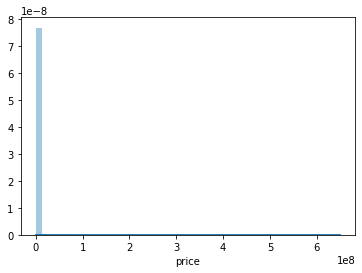

In [37]:
sns.distplot(df.price.loc[(~df.price.isnull())])

Como se puede apreciar en el gráfico, existen valores extremos, lo que le da la larga cola. Además, al estar trabajando con precios en pesos, las magnitudes se ven exageradas, por lo que trabajeremos con los precios en dólares.


In [38]:
df.drop(df.loc[df.price_aprox_usd == df.price_aprox_usd.max()].index, axis=0, inplace=True)

El siguiente gráfico es esencialmente el mismo que el anterior, pero en dólares, lo que permite apreciar el kernel ya que las magnitudes son menores.

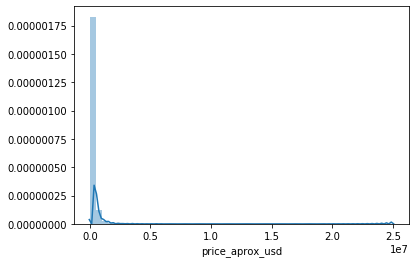

In [39]:
sns.distplot(df.price_aprox_usd.loc[(~df.price.isnull())])

Realizamos un boxplot para ver los outliers

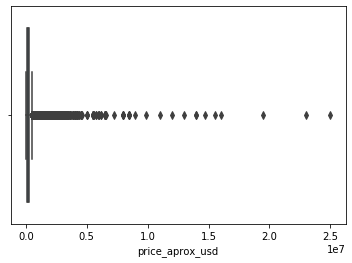

In [40]:
sns.boxplot(df.price_aprox_usd)

Tenemos algunos inmuebles con valores por encima de 10 millones de dólares, por lo que procedemos a revisarlos

In [41]:
df.loc[df.price_aprox_usd > 10000000].filter(['price_aprox_usd', 'lat', 'rooms', 'amb_tit'])

,price_aprox_usd,lat,rooms,amb_tit
525,11000000.00,NaN,NaN,NaN
34638,14000000.00,NaN,NaN,NaN
49083,15500000.00,NaN,NaN,NaN
84400,13000000.00,NaN,NaN,NaN
91229,14000000.00,NaN,NaN,NaN
91289,16000000.00,NaN,NaN,NaN
91428,14700000.00,NaN,NaN,NaN
91468,25000000.00,NaN,NaN,NaN
91479,19500000.00,NaN,NaN,NaN
107390,22980378.29,NaN,NaN,NaN


Aprovechamos el hecho de que les falta información de variables descriptivas para descartarlos y que son pocas observaciones

In [42]:
df.drop(df.loc[df.price_aprox_usd > 10000000].index, axis=0, inplace=True)

Ahora buscamos outliers en la variable `price_usd_per_m2`

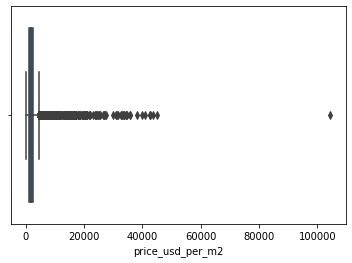

In [43]:
sns.boxplot(df.price_usd_per_m2)

Vemos que existen inmuebles con valores mayores a USD 50.000 por metro cuadrado

In [44]:
df.loc[df.price_usd_per_m2 > 50000].filter(['price_aprox_usd', 'localidad','lat', 'rooms', 'amb_tit','surface_total_in_m2'])

,price_aprox_usd,localidad,lat,rooms,amb_tit,surface_total_in_m2
26193,3657014.0,Boedo,NaN,1.0,NaN,35.0


Procedemos a descartarlo

In [45]:
df.drop(df.loc[df.price_usd_per_m2 > 50000].index, axis=0, inplace=True)

'Ejecutamos el mismo boxplot de recién para verificar los cambios'

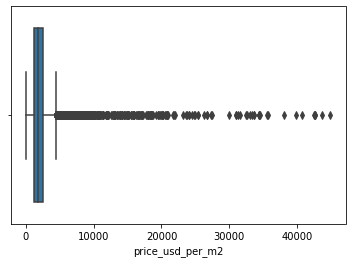

In [46]:
sns.boxplot(df.price_usd_per_m2); 'Ejecutamos el mismo boxplot de recién para verificar los cambios'

Realizamos un gráfico para ver la distribución de precios en dólares según tipo de inmueble

E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


'PH en Azul, apartment en Naranja, house en Verde y store en Rojo'

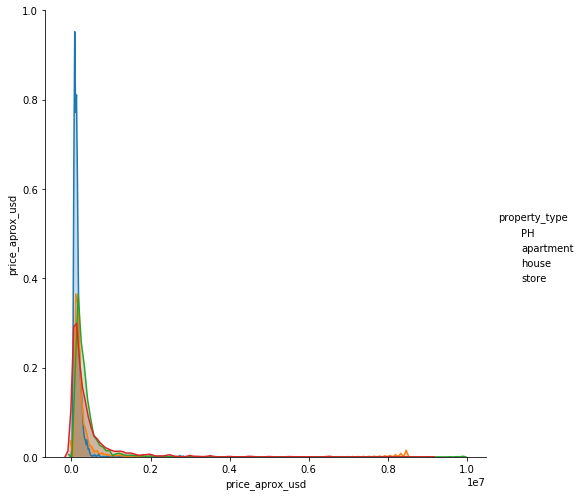

In [47]:
sns.pairplot(df, vars=['price_aprox_usd'], hue='property_type', height=7, markers='property_type'); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'

Ahora realizamos el mismo gráfico pero sobre `log_price_aprox_usd`, para apreciar la transformación

'PH en Azul, apartment en Naranja, house en Verde y store en Rojo'

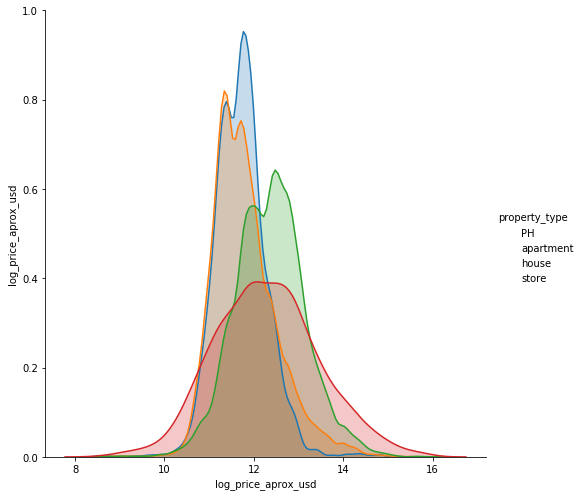

In [48]:
sns.pairplot(df, vars=['log_price_aprox_usd'], hue='property_type', height=7, markers='property_type' ); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'

Y también sobre `price_usd_per_m2`y `log_price_usd_per_m2`

E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
E:\Miniconda3\envs\ds37\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


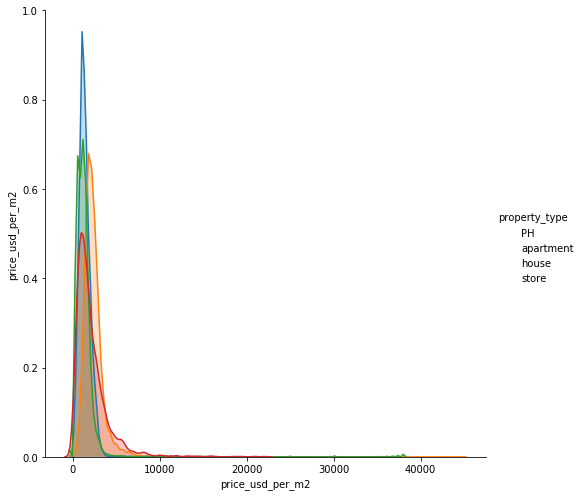

In [77]:
sns.pairplot(df, vars=['price_usd_per_m2'], hue='property_type', height=7, markers='property_type'); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'
plt.savefig('p_per_m2_usd.png')

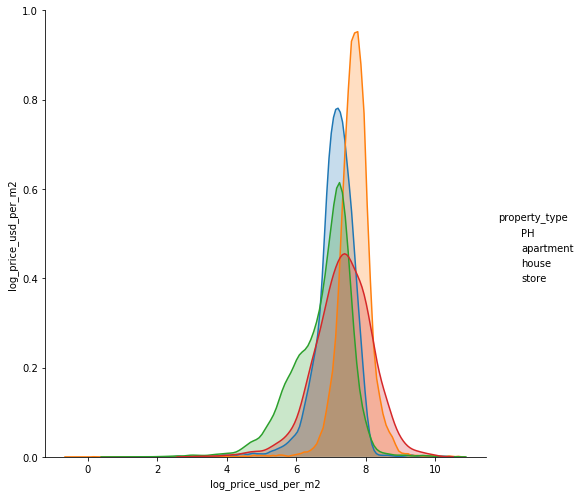

In [78]:
sns.pairplot(df, vars=['log_price_usd_per_m2'], hue='property_type', height=7, markers='property_type'); 'PH en Azul, \
apartment en Naranja, house en Verde y store en Rojo'
plt.savefig('log_p_per_m2_usd.png')

Nos concentramos en la Ciudad Autónoma de Buenos Aires para ver qué barrios tienen el valor por metro cuadrado más elevado según la mediana

In [51]:
caba = df.loc[(df.provincia== 'Capital Federal')].groupby('localidad')\
                .price_usd_per_m2.median().sort_values(ascending=False)

Graficamos los valores

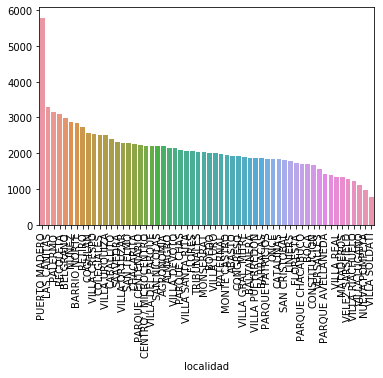

In [81]:
sns.barplot(caba.index, caba.values).set_xticklabels(labels=caba.index, rotation=90);
plt.savefig('median_price.png')

Cargamos los datos de los polígonos de CABA en un nuevo data frame

In [53]:
barrios = pd.read_csv('barrios.csv', encoding='latin1')
barrios.sample(10)

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
38,"POLYGON ((-58.5192540532325 -34.6330100952683,...",LINIERS,9.0,9256.927321,4.374419e+06
6,"POLYGON ((-58.4819203599833 -34.6242871724757,...",VILLA SANTA RITA,11.0,5757.752335,2.153691e+06
15,"POLYGON ((-58.5015376247954 -34.6318345193872,...",VILLA LURO,10.0,8652.930031,2.566937e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
26,"POLYGON ((-58.4708152687488 -34.58744531424,-5...",PARQUE CHAS,15.0,4531.253396,1.385412e+06
8,"POLYGON ((-58.525116079791 -34.613999981063,-5...",VILLA REAL,10.0,5070.965652,1.334146e+06
29,"POLYGON ((-58.3703353711449 -34.6329258371189,...",BARRACAS,4.0,13018.210271,7.961000e+06
10,"POLYGON ((-58.4833907036583 -34.6241108718058,...",FLORESTA,10.0,7519.654092,2.320641e+06
23,"POLYGON ((-58.4466910921417 -34.569065630363,-...",COLEGIALES,13.0,6374.619045,2.289774e+06


In [54]:
# definimos una funcion para convertirlo en GeoDataFrame
def from_wkt(df, wkt_column):
    import shapely.wkt
    df["coordinates"]= df[wkt_column].apply(shapely.wkt.loads)
    gdf = gpd.GeoDataFrame(barrios, geometry='coordinates')
    return gdf

barrios = from_wkt(barrios, "WKT")

Debido a que tenemos diferencias en los nombres de nuestro df original y el de barrios, procedemos a unificar los nombres

In [55]:
caba.index = caba.index.str.upper()

In [56]:
caba.index = caba.index.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [57]:
caba.rename({'NUNEZ':'NUÑEZ', 'VILLA GENERAL MITRE': 'VILLA GRAL. MITRE',\
                     'POMPEYA':'NUEVA POMPEYA', 'CONSTITUCIÓN':'CONSTITUCION' }, inplace=True)

In [58]:
precios_barrios = barrios.merge(caba, how='left', left_on='BARRIO', right_on=caba.index)

In [59]:
caba.index

Index(['PUERTO MADERO', 'LAS CANITAS', 'PALERMO', 'RECOLETA', 'BELGRANO',
       'NUÑEZ', 'BARRIO NORTE', 'RETIRO', 'COGHLAN', 'VILLA CRESPO',
       'COLEGIALES', 'VILLA URQUIZA', 'CABALLITO', 'SAAVEDRA', 'VILLA ORTUZAR',
       'SAN TELMO', 'CHACARITA', 'PARQUE CENTENARIO', 'CENTRO / MICROCENTRO',
       'VILLA DEL PARQUE', 'SAN NICOLAS', 'AGRONOMIA', 'ALMAGRO',
       'VILLA DEVOTO', 'PARQUE CHAS', 'VILLA SANTA RITA', 'FLORES',
       'TRIBUNALES', 'MONSERRAT', 'BOEDO', 'VILLA LURO', 'PATERNAL',
       'MONTE CASTRO', 'ABASTO', 'CONGRESO', 'VILLA GRAL. MITRE', 'BALVANERA',
       'VILLA PUEYRREDON', 'BARRACAS', 'PARQUE PATRICIOS', 'ONCE', 'CATALINAS',
       'SAN CRISTOBAL', 'LINIERS', 'FLORESTA', 'PARQUE CHACABUCO', 'BOCA',
       'CONSTITUCION', 'VERSALLES', 'PARQUE AVELLANEDA', '', 'VILLA REAL',
       'MATADEROS', 'VELEZ SARSFIELD', 'VILLA RIACHUELO', 'VILLA LUGANO',
       'NUEVA POMPEYA', 'VILLA SOLDATI'],
      dtype='object', name='localidad')

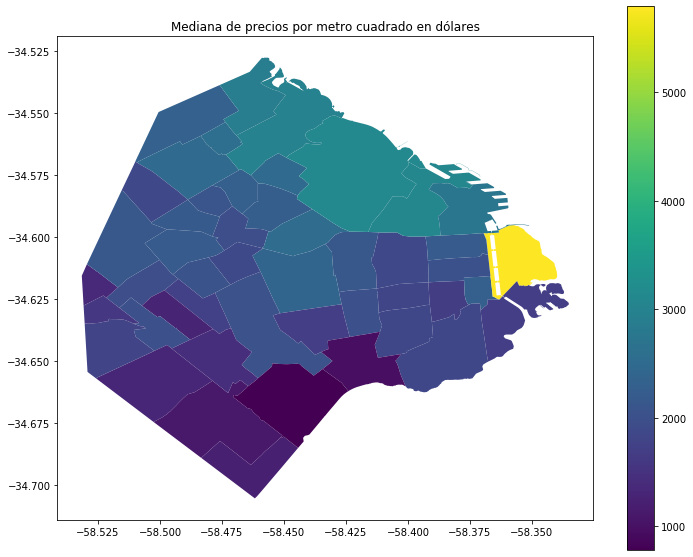

In [76]:
precios_barrios.plot('price_usd_per_m2', figsize=(12,10), legend=True);
plt.title('Mediana de precios por metro cuadrado en dólares');
plt.savefig('mapa_precios.png')

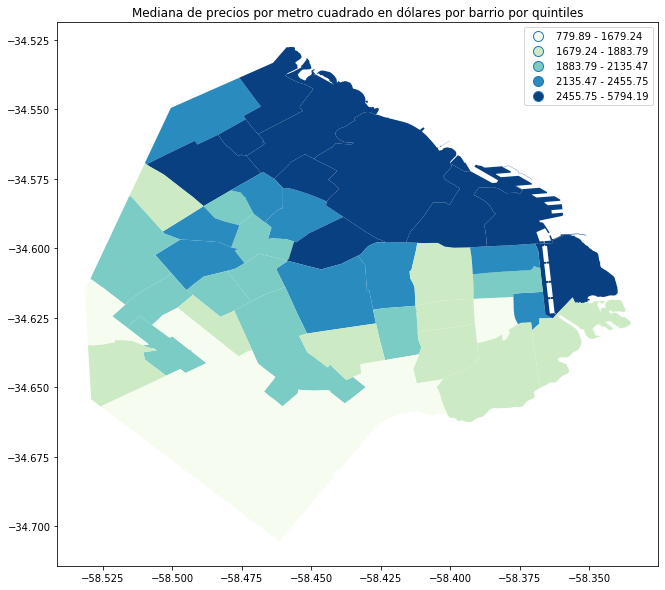

In [61]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))

precios_barrios.plot(column='price_usd_per_m2', scheme='Quantiles', 
        k=5, cmap='GnBu', legend=True, ax=ax)

plt.title('Mediana de precios por metro cuadrado en dólares por barrio por quintiles');

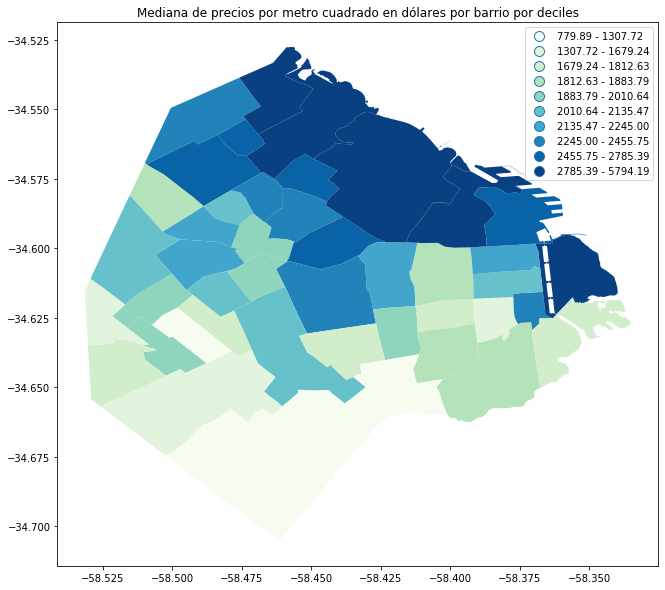

In [62]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))

precios_barrios.plot(column='price_usd_per_m2', scheme='Quantiles', 
        k=10, cmap='GnBu', legend=True, ax=ax, )

plt.title('Mediana de precios por metro cuadrado en dólares por barrio por deciles');

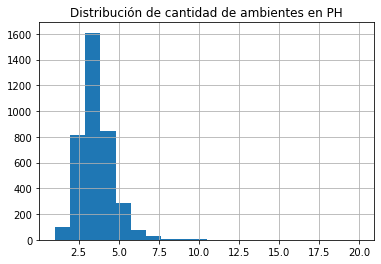

In [63]:
df.loc[df.property_type ==df.property_type.unique()[0]] .rooms.hist(bins=20)
plt.title('Distribución de cantidad de ambientes en PH');

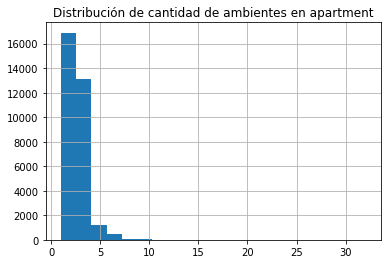

In [64]:
df.loc[df.property_type ==df.property_type.unique()[1]] .rooms.hist(bins=20)
plt.title('Distribución de cantidad de ambientes en apartment');

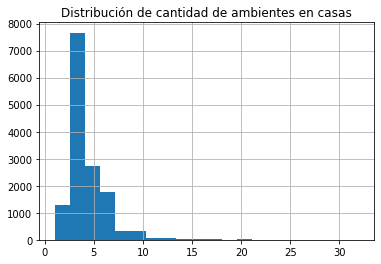

In [65]:
df.loc[df.property_type ==df.property_type.unique()[2]] .rooms.hist(bins=20)
plt.title('Distribución de cantidad de ambientes en casas');

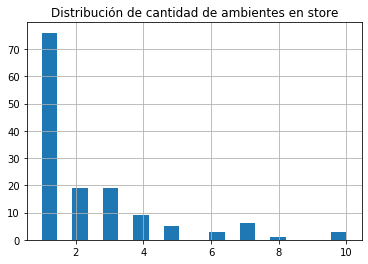

In [66]:
df.loc[df.property_type ==df.property_type.unique()[3]] .rooms.hist(bins=20)
plt.title('Distribución de cantidad de ambientes en store');

Tiramos las columnas innecesarias

In [67]:
df.drop(columns=['floor', 'valores_invertidos', 'pozo', 'cuota', 'financ', 'pais', 'dor_desc',
                 'bath_tit', 'bath_desc', 'amb_desc', 'dor_tit'], inplace=True)

Graficamos la distribución de los metros cuadrados

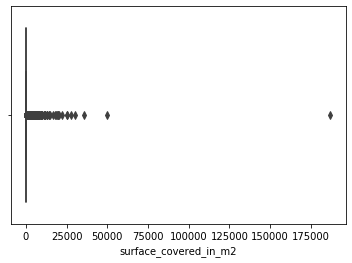

In [68]:
sns.boxplot(df.surface_covered_in_m2);

In [69]:
df.loc[df.surface_covered_in_m2 > 30000].description.unique()

array(['TOTALMENTE LUMINOSO LIVING COMEDOR CON AMPLIO PLACARD .VISTA PANORAMICA COCINA INDEPENDIENTE RECICLADA CORTINADOS MUEBLES Y ARTEFACTOS DE LUZ A ESTRENAR ',
       'Venta de Casa  en CAMPO QUIJANO, Campo Quijano, 4 DORMITORIOS, 2 BAÑOS, LIVING, COMEDOR, COCINA, SOTANO, GALERÍA, QUINCHO CON DOS HABITACIONES, LAVADERO, DEPOSITO. CASA DE HUESPED, UN DORMITORIO, BAÑO, COC-LIVG, COMEDOR, -  - EDUARDO NOMAN PROPIEDADES',
       'Barrio Norte EXCELENTE Semipiso al Frente Balcón Corrido Superficie 187 metros todos los Ambientes Muy Luminosos y Soleados - Palier privado.  4 dormitorios - c/dependencia servicio - 4 bañosRecepción y Comedor,Cocina con Comedor Diario y Lavadero Cochera Fija y gran Baulera Sercios Centrales Edificio con Entrada de Cortesía Expensas Incluye Aysa y Vigilancia $11.000.- '],
      dtype=object)

Como se puede apreciar en las descripciones, los valores de los m2 son erróneos. Procedemos a dropearlos y graficamos nuevamente

In [70]:
df.drop(df.loc[df.surface_covered_in_m2 > 30000].index, axis=0, inplace=True)

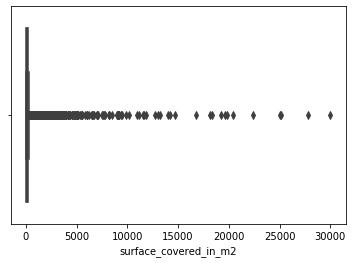

In [71]:
sns.boxplot(df.surface_covered_in_m2);

Los outliers corresponden a locales, lo cual es factible si se tratara de galpones/fábricas

In [72]:
df.drop(columns=['amb_tit', 'expenses', 'cubierta_sobre_total', 'total_sobre_cubierta', 'state_name'], inplace=True)

### Finalmente obtenemos los resultados de cuántas observaciones nos faltan, según la variable

In [73]:
#Obtenemos los porcentajes de datos faltantes de cada columna luego de la limpieza
for cols in df.columns:
    nulos = df[cols].isnull().sum()
    porcentaje = nulos/len(df)
    print(f'{porcentaje*100:.0f}%', cols)

0% property_type
0% place_name
16% geonames_id
15% price
15% currency
15% price_aprox_local_currency
15% price_aprox_usd
11% surface_total_in_m2
11% surface_covered_in_m2
43% price_usd_per_m2
27% price_per_m2
53% rooms
0% description
0% title
41% lat
41% lon
99% precio_regex
99% moneda
0% provincia
0% localidad
65% barrio
15% log_price
15% log_price_aprox_usd
43% log_price_usd_per_m2


In [74]:
df.shape

(106528, 24)